In [39]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm

/var/folders/p0/kgfq_z9j4d59b68jgyqqwv180000gn/T/ipykernel_32634/2985703969.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [11]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")

In [42]:
class TraceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = torch.tensor(train_frame.iloc[idx]['input'], dtype=torch.float32)
        target = torch.tensor(train_frame.iloc[idx]['target'], dtype=torch.float32)
        return input, target

train_dataset = TraceDataset(train_frame)
test_dataset = TraceDataset(test_frame)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [43]:
def bicycle_model_eval(input):
    # This version takes in an input of dim 5
    trace = []#torch.zeros((80, 3))
    states = []#torch.zeros((80, 5))
    start_x = input[0]
    start_y = input[1]
    start_theta = input[2]
    start_v = input[3]
    #trace[0,0:3] = input[0:3]
    trace.append(input[0:3])
    L = 0.3302
    TS = 0.1
    X, Y, THETA = 0, 1, 2
    dX, dY, dTHETA, dV, V = 0, 1, 2, 3, 4
    #states[0, 0:3] = input[0:3]
    #states[0, V] = input[3]
    states.append(torch.tensor([input[0],input[1],input[2],input[5],input[3]]))
    for i in range(1,80):
        # Advance bicycle model
        states.append([states[-1][V] * torch.cos(trace[-1][THETA]),
                       states[-1][V] * torch.sin(trace[-1][THETA]),
                       (states[-1][V] * torch.tan(input[4])) / L,
                       input[5],
                       states[i-1][V] + TS*input[5]])
        #states[i, dX] = states[i-1,V] * torch.cos(trace[i-1,THETA])
        #states[i, dY] = states[i-1,V] * torch.sin(trace[i-1,THETA])
        #states[i, dTHETA] = (states[i-1,V] * torch.tan(input[4])) / L
        #states[i, dV] = input[5]
        #states[i, V] = states[i-1, V] + TS*states[i, dV]
        trace.append(trace[-1] + TS*torch.tensor(states[-1][0:3], dtype=torch.float32))
    return torch.vstack(trace)

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=10, target_size=6):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, target_size)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        return output

In [44]:
net = LSTMPredictor()

In [45]:
torch.tensor(train_frame.iloc[0]['input'])

tensor([[-58.9267,  31.1195,   2.0114],
        [-59.0875,  31.4569,   2.0265],
        [-59.2471,  31.7847,   2.0320],
        [-59.4060,  32.1001,   2.0484],
        [-59.5651,  32.4038,   2.0645],
        [-59.7262,  32.6999,   2.0798],
        [-59.8943,  32.9917,   2.1144],
        [-60.0724,  33.2777,   2.1533],
        [-60.2605,  33.5560,   2.1888],
        [-60.4569,  33.8287,   2.2108]], dtype=torch.float64)

In [46]:
outp = net(torch.tensor(train_frame.iloc[0]['input'], dtype=torch.float32))
outp.shape

torch.Size([10, 6])

In [47]:
outp[-1]

tensor([ 0.1566,  0.1562, -0.0921, -0.1798, -0.2540, -0.2208],
       grad_fn=<SelectBackward0>)

In [48]:
outp_trace = bicycle_model_eval(outp[-1])
outp_trace

tensor([[ 1.5665e-01,  1.5621e-01, -9.2099e-02],
        [ 1.3875e-01,  1.5786e-01, -7.7969e-02],
        [ 1.1862e-01,  1.5943e-01, -6.2103e-02],
        [ 9.6273e-02,  1.6082e-01, -4.4502e-02],
        [ 7.1697e-02,  1.6192e-01, -2.5164e-02],
        [ 4.4896e-02,  1.6259e-01, -4.0905e-03],
        [ 1.5878e-02,  1.6271e-01,  1.8719e-02],
        [-1.5342e-02,  1.6212e-01,  4.3264e-02],
        [-4.8745e-02,  1.6068e-01,  6.9545e-02],
        [-8.4301e-02,  1.5820e-01,  9.7562e-02],
        [-1.2197e-01,  1.5452e-01,  1.2731e-01],
        [-1.6171e-01,  1.4943e-01,  1.5880e-01],
        [-2.0344e-01,  1.4274e-01,  1.9203e-01],
        [-2.4710e-01,  1.3426e-01,  2.2699e-01],
        [-2.9259e-01,  1.2375e-01,  2.6368e-01],
        [-3.3979e-01,  1.1101e-01,  3.0212e-01],
        [-3.8858e-01,  9.5802e-02,  3.4228e-01],
        [-4.3879e-01,  7.7910e-02,  3.8419e-01],
        [-4.9027e-01,  5.7101e-02,  4.2783e-01],
        [-5.4279e-01,  3.3151e-02,  4.7320e-01],
        [-5.9614e-01

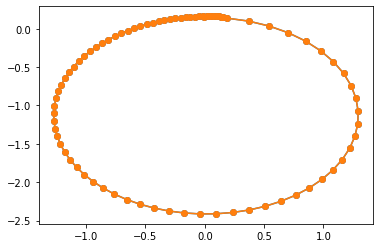

In [49]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o')
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o')

In [50]:
torch.vstack([torch.rand((3,)) for _ in range(10)])

tensor([[0.0237, 0.2363, 0.6993],
        [0.1403, 0.7152, 0.9534],
        [0.6646, 0.1769, 0.5213],
        [0.6292, 0.8642, 0.6178],
        [0.4133, 0.0582, 0.9849],
        [0.5114, 0.4496, 0.9888],
        [0.3597, 0.7794, 0.3055],
        [0.6900, 0.4302, 0.3716],
        [0.2551, 0.4389, 0.6044],
        [0.3002, 0.7575, 0.6179]])

In [51]:
loss = nn.MSELoss()
loss(outp_trace,torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32))

tensor(2352.4453, grad_fn=<MseLossBackward0>)

In [53]:
# Training Loop
torch.autograd.set_detect_anomaly(True)
net = LSTMPredictor()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(100):
    cum_train_loss = 0.0
    for input_data, target_data in tqdm(train_dataloader):
        net.zero_grad()
        outp = net(input_data)
        print(outp.shape)
        outp_trace = bicycle_model_eval(outp[-1])
        loss = loss_func(outp_trace, target_data)
        loss.backward()
        optimizer.step()
        cum_train_loss += loss.item()
    plt.title(f"Epoch {epoch} training plot")
    plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label="Predicted")
    plt.plot(target_data[:,0].detach().numpy(), target_data[:,1].detach().numpy(), marker='o', label="Truth")
    plt.legend()
    plt.show()
    cum_train_loss /= len(train_dataset)
    print(cum_train_loss)
    cum_test_loss = 0.0
    with torch.no_grad():
        for input_data, target_data in tqdm(test_dataloader):
            outp = net(input_data)
            outp_trace = bicycle_model_eval(outp[-1])
            loss = loss_func(outp_trace, target_data)
            cum_test_loss += loss.item()
        plt.title(f"Epoch {epoch} testing plot")
        plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label="Predicted")
        plt.plot(target_data[:,0].detach().numpy(), target_data[:,1].detach().numpy(), marker='o', label="Truth")
        plt.legend()
        plt.show()
    cum_test_loss /= len(test_dataset)
    print(cum_test_loss)
    print(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")

  0%|          | 0/470 [00:00<?, ?it/s]

torch.Size([1, 10, 6])


ValueError: only one element tensors can be converted to Python scalars